In [222]:
using Pkg
Pkg.instantiate()

In [223]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO, Dates, Serialization, Chain, DataFramesMeta
using Statistics, FFTW
import ColorSchemes as co 

In [224]:
image_data = "data//metrics"
for (i,x) in enumerate(readdir(image_data))
    println(i,"  ",x)
end

1  20_col_3_grow_type_22023_12_20.csv
2  20_col_3_grow_type_22023_12_20.jls
3  32_col_3_grow_type_22023_12_19.csv
4  32_col_3_grow_type_22023_12_19.jls
5  8_col_3_grow_type_22023_12_19.csv
6  8_col_3_grow_type_22023_12_19.jls
7  9_col_3_grow_type_22023_12_20.csv
8  9_col_3_grow_type_22023_12_20.jls
9  artifical_2023_09_14.csv
10  artifical_2023_09_14.jls
11  artifical_2023_long_evo.csv
12  artifical_2023_long_evo.jls
13  data_sets_10_2023-09-26.csv
14  data_sets_10_2023-09-26.jls


In [226]:
data_a = deserialize(joinpath(image_data,readdir(image_data)[2]))
first(data_a,2)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,Random 2023_12_20,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[63, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 63]","[5333, 5471, 5465, 5494, 5627, 5688, 5527, 5623, 5609, 5557 … 5450, 5595, 5612, 5599, 5489, 5624, 5571, 5566, 5500, 5460]","[5482, 5689, 5540, 5428, 5588, 5533, 5405, 5557, 5548, 5672 … 5509, 5778, 5706, 5577, 5498, 5489, 5664, 5475, 5643, 5572]",20589
2,Random 2023_12_20,Colony 1 artifical,2,"[4, 3, 1, 3, 1, 3, 3, 2, 3, 9 … 2, 1, 3, 2, 3, 5, 6, 6, 2, 4]","[2, 1, 1, 0, 2, 1, 1, 0, 1, 7 … 1, 1, 1, 0, 1, 3, 3, 3, 0, 2]","[4712, 6938, 5217, 5183, 5761, 5770, 5356, 4873, 6019, 5613 … 5810, 5925, 4959, 5359, 5842, 5683, 5156, 5248, 6349, 5178]","[5186, 7844, 5853, 5147, 5748, 5612, 5817, 4841, 5866, 6497 … 5785, 5583, 4624, 5869, 5237, 5964, 4752, 5402, 5883, 4981]",20589


In [227]:
unique(data_a.data_set)

3-element Vector{String}:
 "Random 2023_12_20"
 "Finger_weak 2023_12_20"
 "Finger_strong 2023_12_20"

In [228]:
data_r = deserialize(joinpath(image_data,readdir(image_data)[end]))
first(data_r,2)

Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,10_04_23_stacked_half_res,Kolonie 1.tif,0,"[0, 0, 9, 6, 10, 7, 10, 8, 9, 10 … 7, 10, 9, 8, 10, 7, 10, 6, 9, 31]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5559, 4601, 5198, 5279, 5880, 5995, 5346, 5303, 5640, 5372 … 5580, 5552, 5217, 5350, 5937, 5874, 5349, 5206, 4648, 4117]","[5758, 4674, 5309, 5623, 5806, 5562, 5455, 5559, 5864, 5365 … 5462, 5770, 5571, 5404, 5380, 5718, 5610, 5264, 4708, 6501]",2992
2,10_04_23_stacked_half_res,Kolonie 1.tif,24,"[0, 0, 1, 1, 0, 1, 1, 0, 1, 0 … 0, 1, 1, 1, 3, 3, 4, 7, 14, 1]","[0, 0, 5, 4, 1, 5, 1, 4, 3, 4 … 3, 5, 4, 4, 1, 5, 1, 4, 5, 5]","[4967, 9556, 9432, 9550, 9202, 9044, 8702, 8631, 8167, 7888 … 5577, 5452, 5697, 5454, 5400, 5359, 5500, 5342, 5361, 2877]","[13720, 12768, 12385, 12375, 11863, 11534, 11136, 10556, 10170, 9835 … 5472, 5267, 5013, 5112, 4762, 4758, 4721, 4655, 4557, 6184]",2992


In [229]:
data_full = filter(row -> row.data_set[end-7:end] =="full_res", data_r )
unique(data_full.data_set)

4-element Vector{String}:
 "14_06_23_stacked_full_res"
 "17_05_23_stacked_full_res"
 "19_12_22_stacked_full_res"
 "26_06_23_stacked_full_res"

In [230]:
path = "analysis\\comparison"
mkpath(path)

ana_para = analysis_parameters(plot_theme =
    Theme(  fontsize = 30,
    size = (1000,800),
    Scatter = (markersize = 18,
    label = "Real Colonies",),                
    Lines  = (linewidth =4,),
    Errorbars = (whiskerwidth = 20, 
    color = :black)
    ))
update_theme!(ana_para.plot_theme)

In [231]:
pair_max_single = @chain data_a begin
    groupby([:time,:data_set])
    @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
    :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

first(pair_max_single, 3)

pair_max_r = @chain data_full begin
    groupby(:time)
     @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
end

Row,time,pair_og,pair_og_stdd
,Int64,Float64,Float64
1,0,0.0590085,0.0193867
2,3,0.534521,0.406161
3,4,0.603532,0.221662
4,19,0.458936,0.274609
5,20,0.318402,0.1617
6,24,0.684652,0.22927
7,43,1.12358,0.163496
8,44,1.01706,0.190581
9,48,1.25448,0.281709


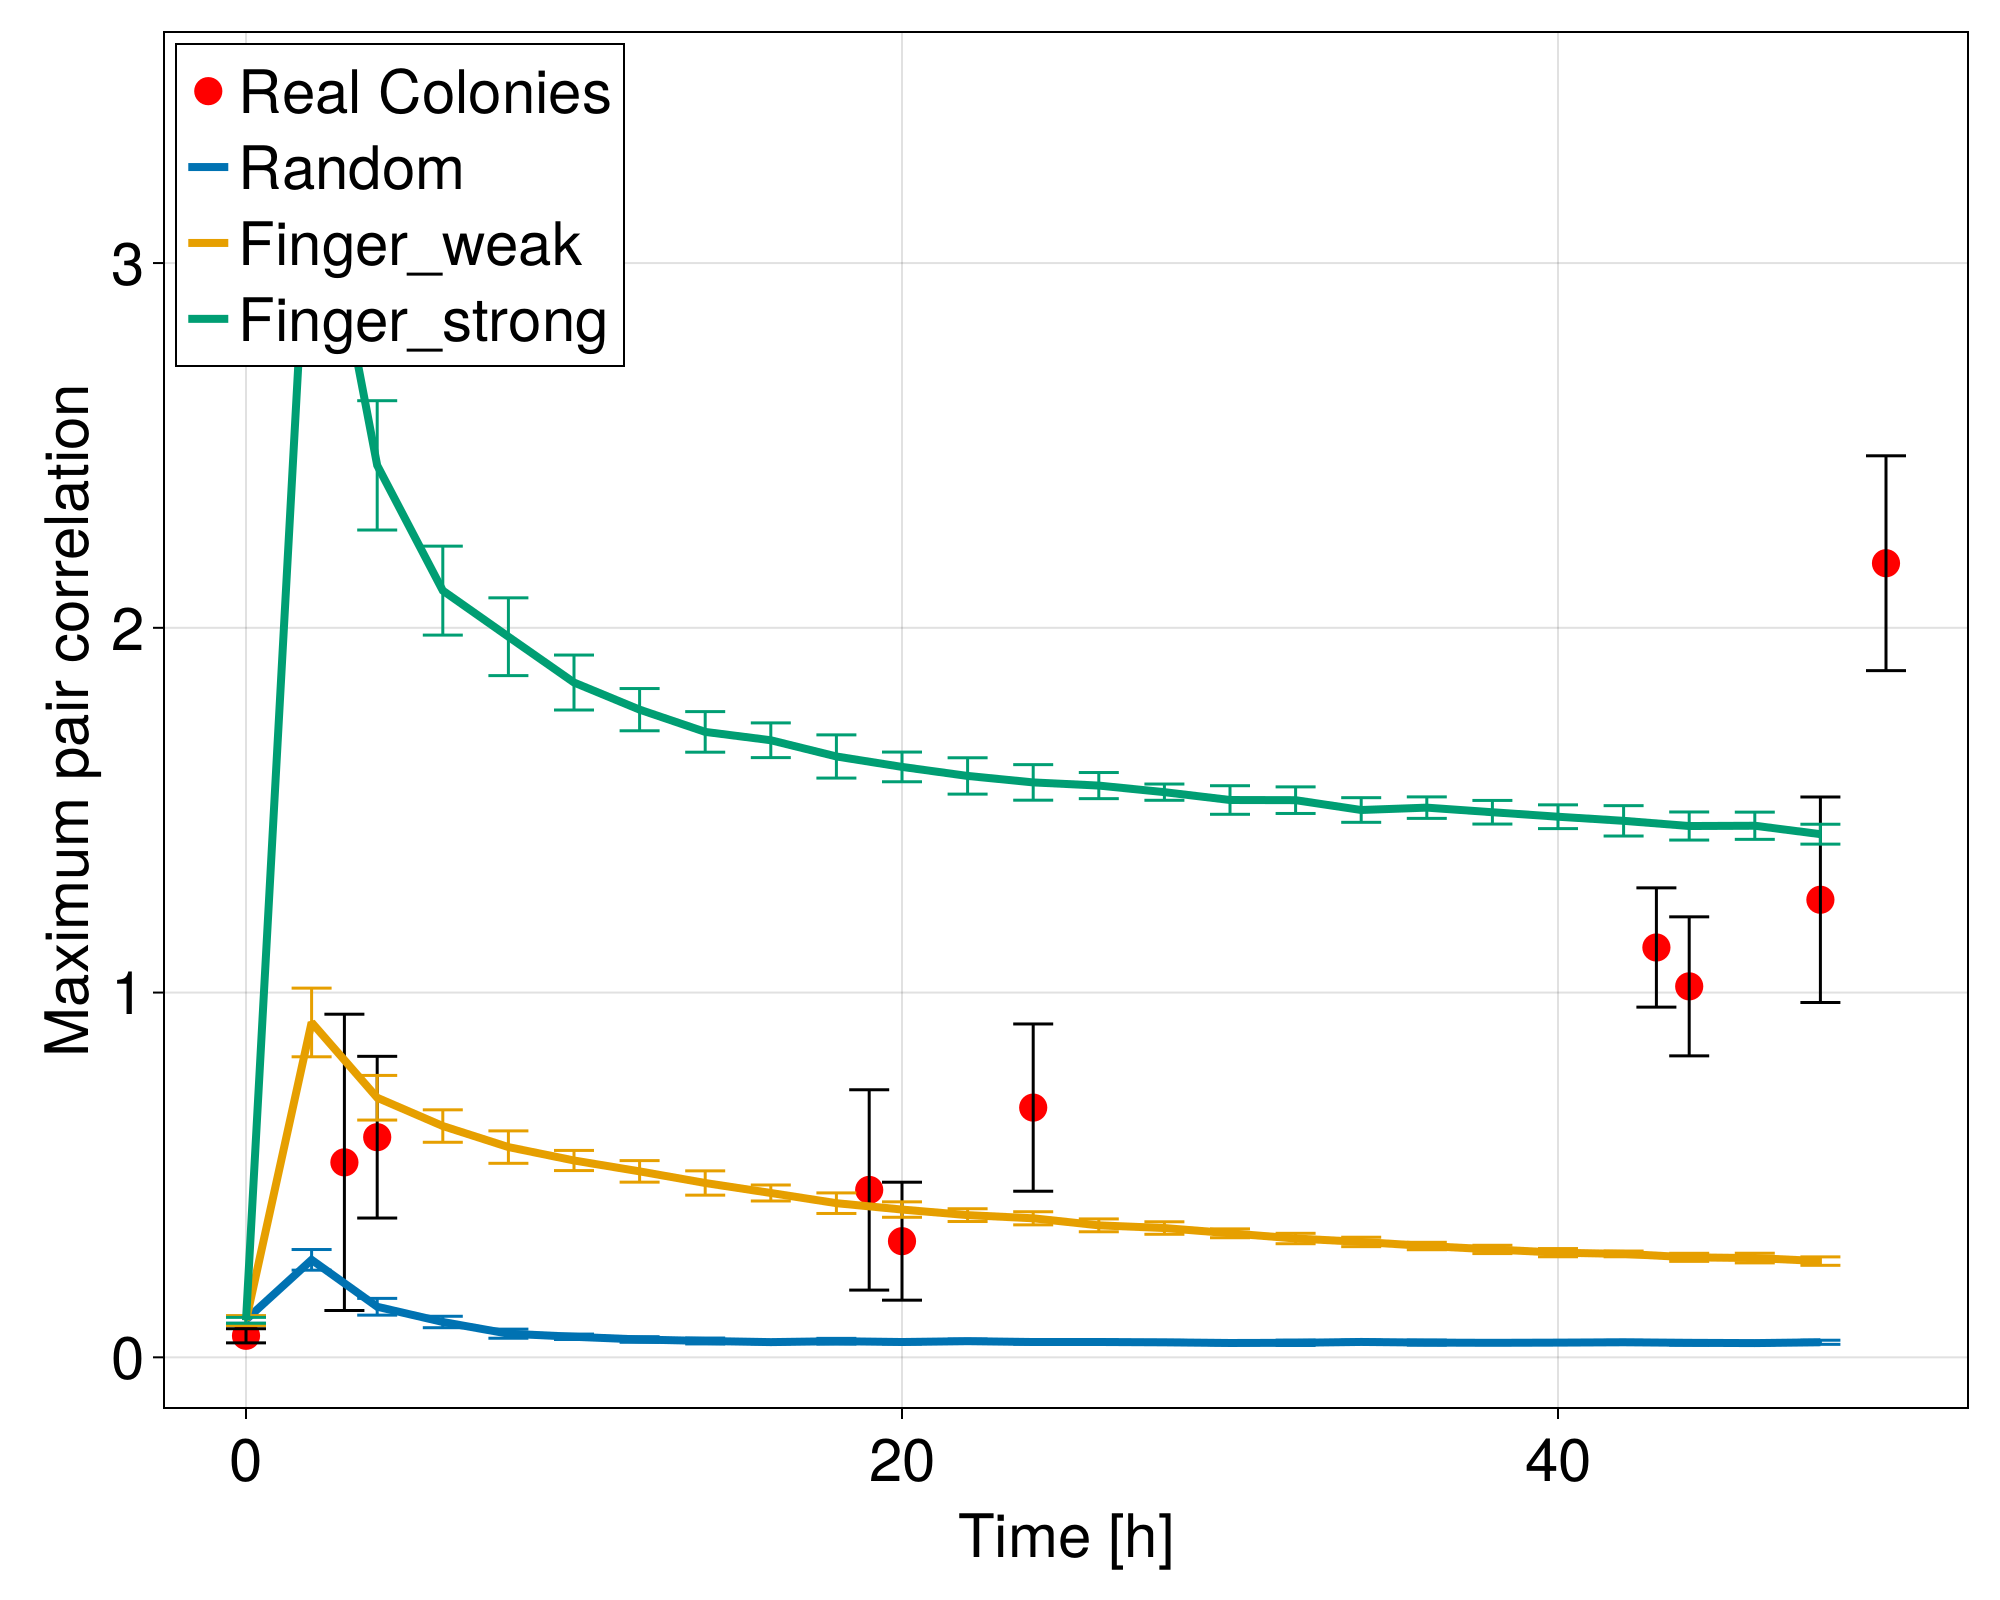

In [232]:
fig1 = Figure()
ax = CairoMakie.Axis(fig1[1,1])
scatter!(ax,pair_max_r.time,pair_max_r.pair_og, markersize = 20, color = "red")
errorbars!(ax,pair_max_r.time,pair_max_r.pair_og, pair_max_r.pair_og_stdd,whiskerwidth = 20, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Maximum pair correlation"
j = 1
for (k, i) in pairs(groupby(pair_max_single,:data_set))
    lines!(ax, i.time, i.pair_og, label = mk_label(k.data_set),linewidth = 4)
    errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_MaxP1.pdf"),fig1)
fig1

## root mean square fluctations

In [233]:
cv_angular_max = @chain data_a begin
    groupby(:time)
    @combine(:cv_angu = mean(std.(:metric_cov)./(mean.(:metric_cov))), :cv_angu_std = std(std.(:metric_cov)./(mean.(:metric_cov))))
end
first(cv_angular_max,3)

cv_angular_max_single = @chain data_a begin 
    groupby([:time,:data_set])
    @combine(:cv_angu = mean(std.(:metric_cov)./(mean.(:metric_cov))), :cv_angu_std = std(std.(:metric_cov)./(mean.(:metric_cov))))
end
first(cv_angular_max_single,3)

Row,time,data_set,cv_angu,cv_angu_std
,Int64,String,Float64,Float64
1,0,Random 2023_12_20,0.0831762,0.0
2,2,Random 2023_12_20,0.736128,0.0320698
3,4,Random 2023_12_20,0.681013,0.0311497


In [234]:
cv_angular_max_r = @chain data_full begin
    groupby(:time)
    @combine(:cv_OG = mean(std.(:metric_OG)./(mean.(:metric_OG))),:cv_OG_std = std(std.(:metric_OG)./(mean.(:metric_OG))))
end

Row,time,cv_OG,cv_OG_std
,Int64,Float64,Float64
1,0,NaN,NaN
2,3,0.695513,0.237475
3,4,0.720371,0.135934
4,19,0.639922,0.231289
5,20,0.548096,0.151844
6,24,0.818629,0.145498
7,43,1.06527,0.0807563
8,44,1.01741,0.09607
9,48,1.12087,0.124787


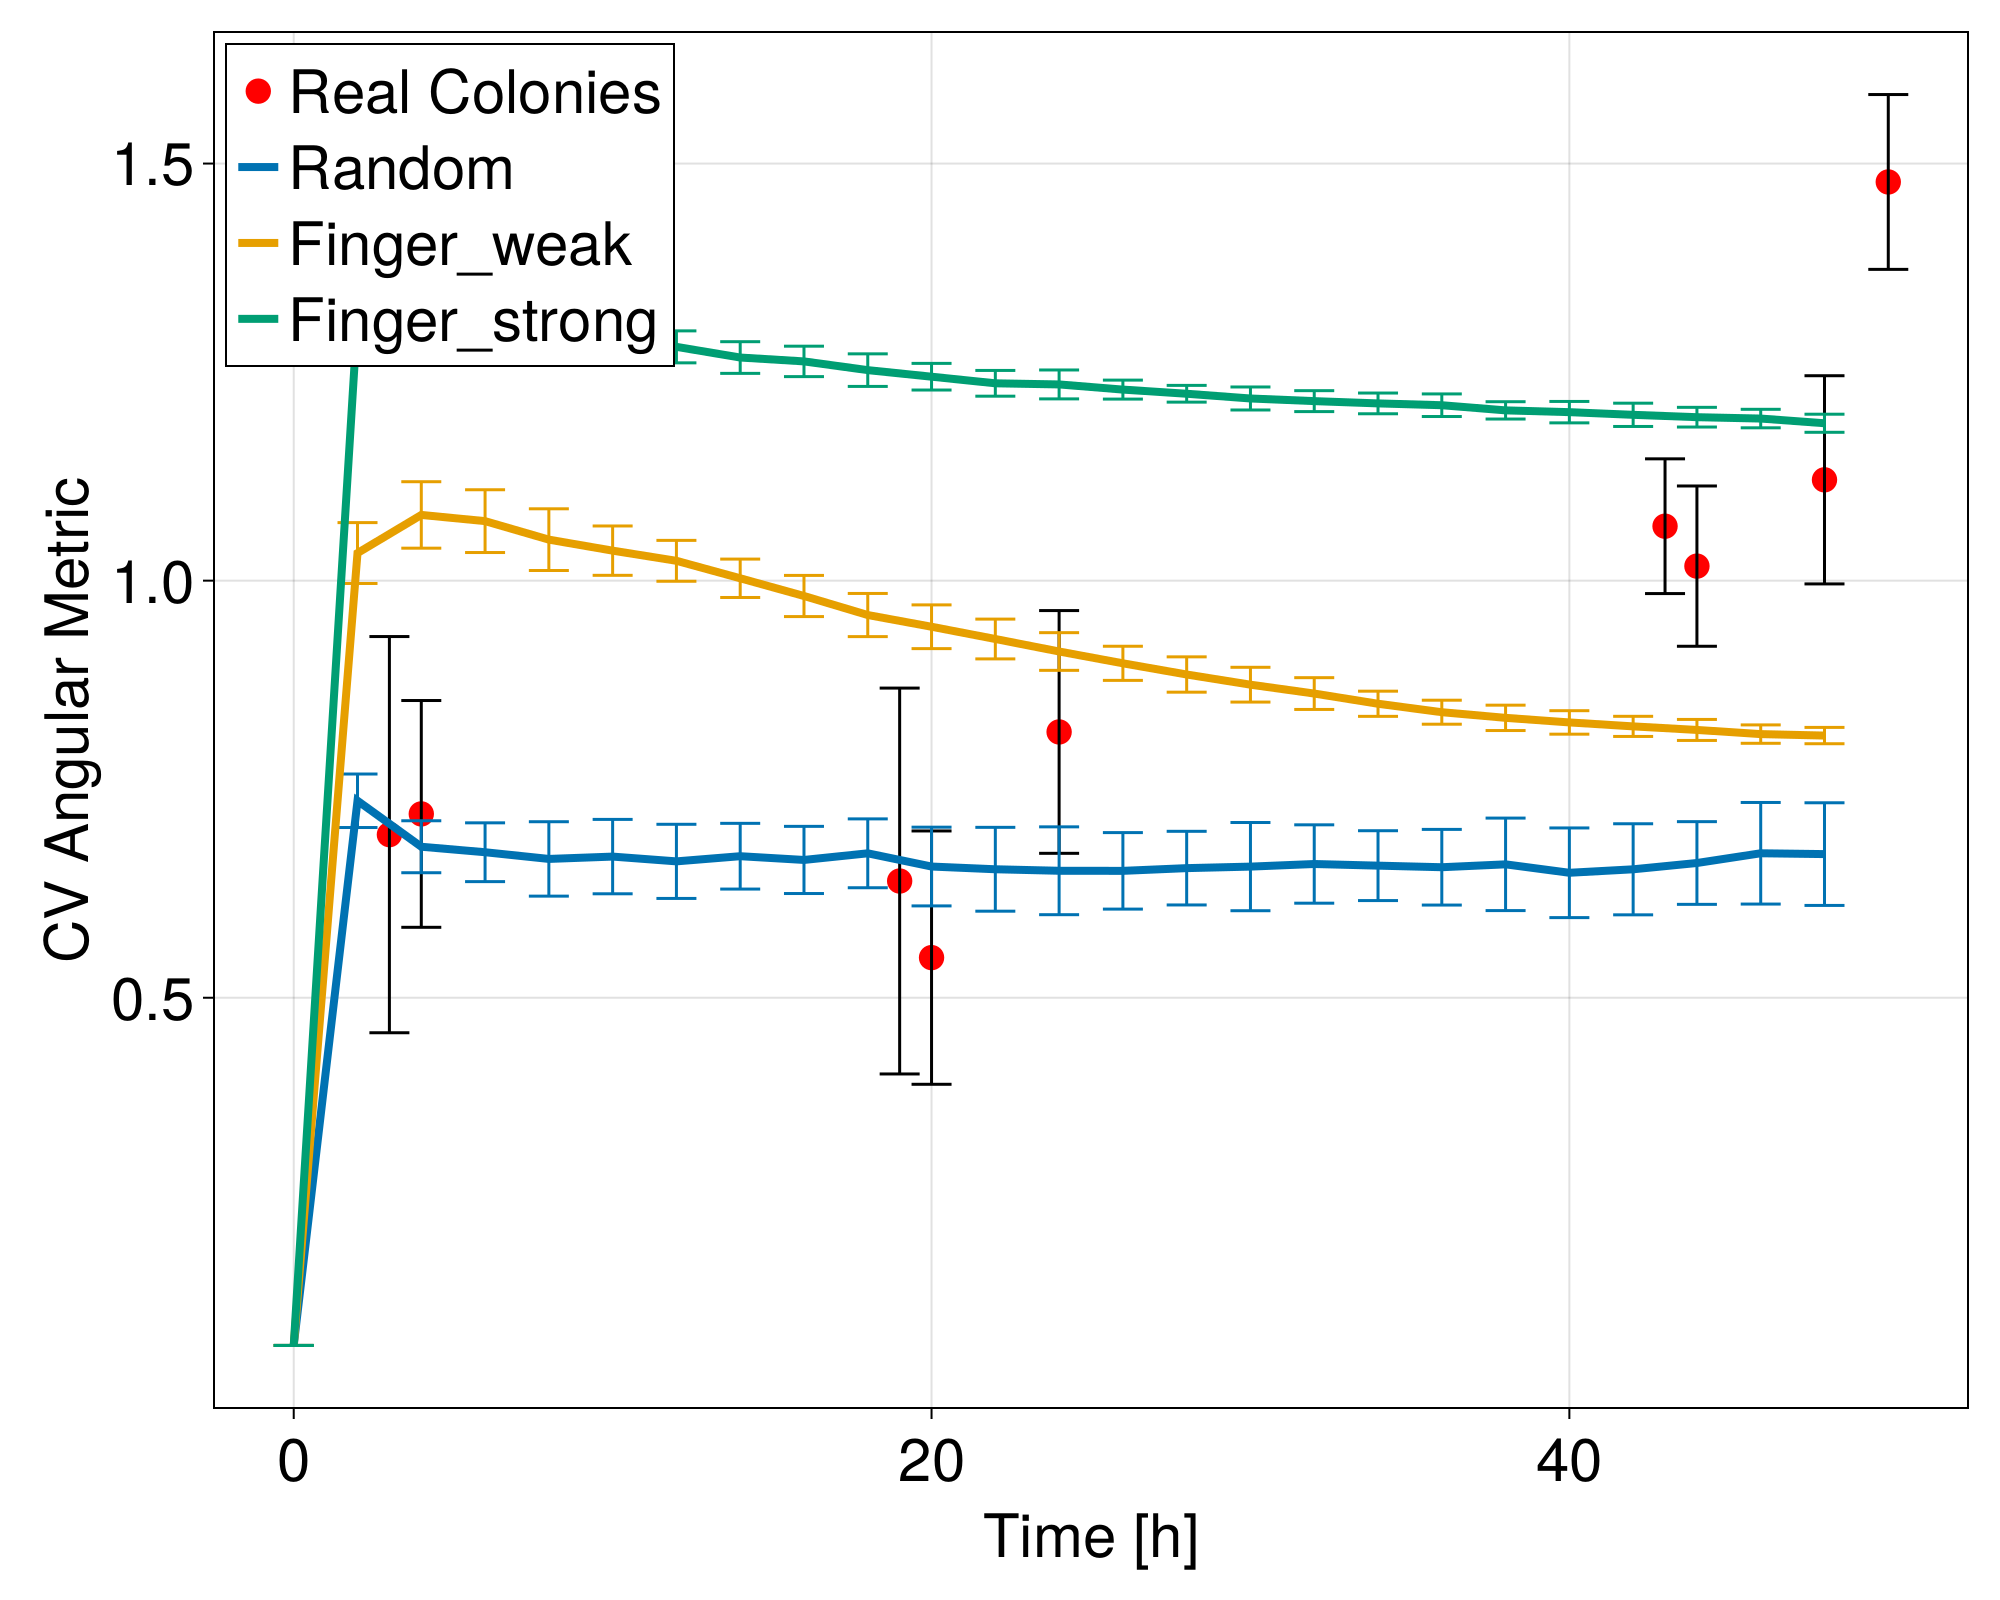

In [235]:
fig3 = Figure()
ax = CairoMakie.Axis(fig3[1,1])
scatter!(ax,cv_angular_max_r.time,cv_angular_max_r.cv_OG, color = :red)
errorbars!(ax,cv_angular_max_r.time,cv_angular_max_r.cv_OG, cv_angular_max_r.cv_OG_std, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="CV Angular Metric"
j = 1
for (k, i) in pairs(groupby(cv_angular_max_single,:data_set))
    lines!(ax, i.time, i.cv_angu, label  = mk_label(k.data_set))
    errorbars!(ax, i.time, i.cv_angu,i.cv_angu_std )
    j += 1
end
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_CV.pdf"),fig3)
fig3

## Root mean square fluctations/roughness

In [236]:
roughness_angular_max_single = @chain data_a begin 
    groupby([:time,:data_set])
    @combine(:roughness_angu = mean(std.(:metric_cov)))
end
first(roughness_angular_max_single)

Row,time,data_set,roughness_angu
,Int64,String,Float64
1,0,Random 2023_12_20,4.75698


In [237]:
roughness_angular_max_r = @chain data_full begin
    groupby(:time)
    @combine(:roughness_OG = mean(std.(:metric_OG)),:roughness_OG_std = std(std.(:metric_OG)))
end

Row,time,roughness_OG,roughness_OG_std
,Int64,Float64,Float64
1,0,0.0,0.0
2,3,4.52467,4.76343
3,4,3.01044,1.35788
4,19,34.7599,21.9436
5,20,23.0157,7.95766
6,24,48.8446,23.8872
7,43,181.523,33.9552
8,44,151.611,29.2072
9,48,185.017,52.0155


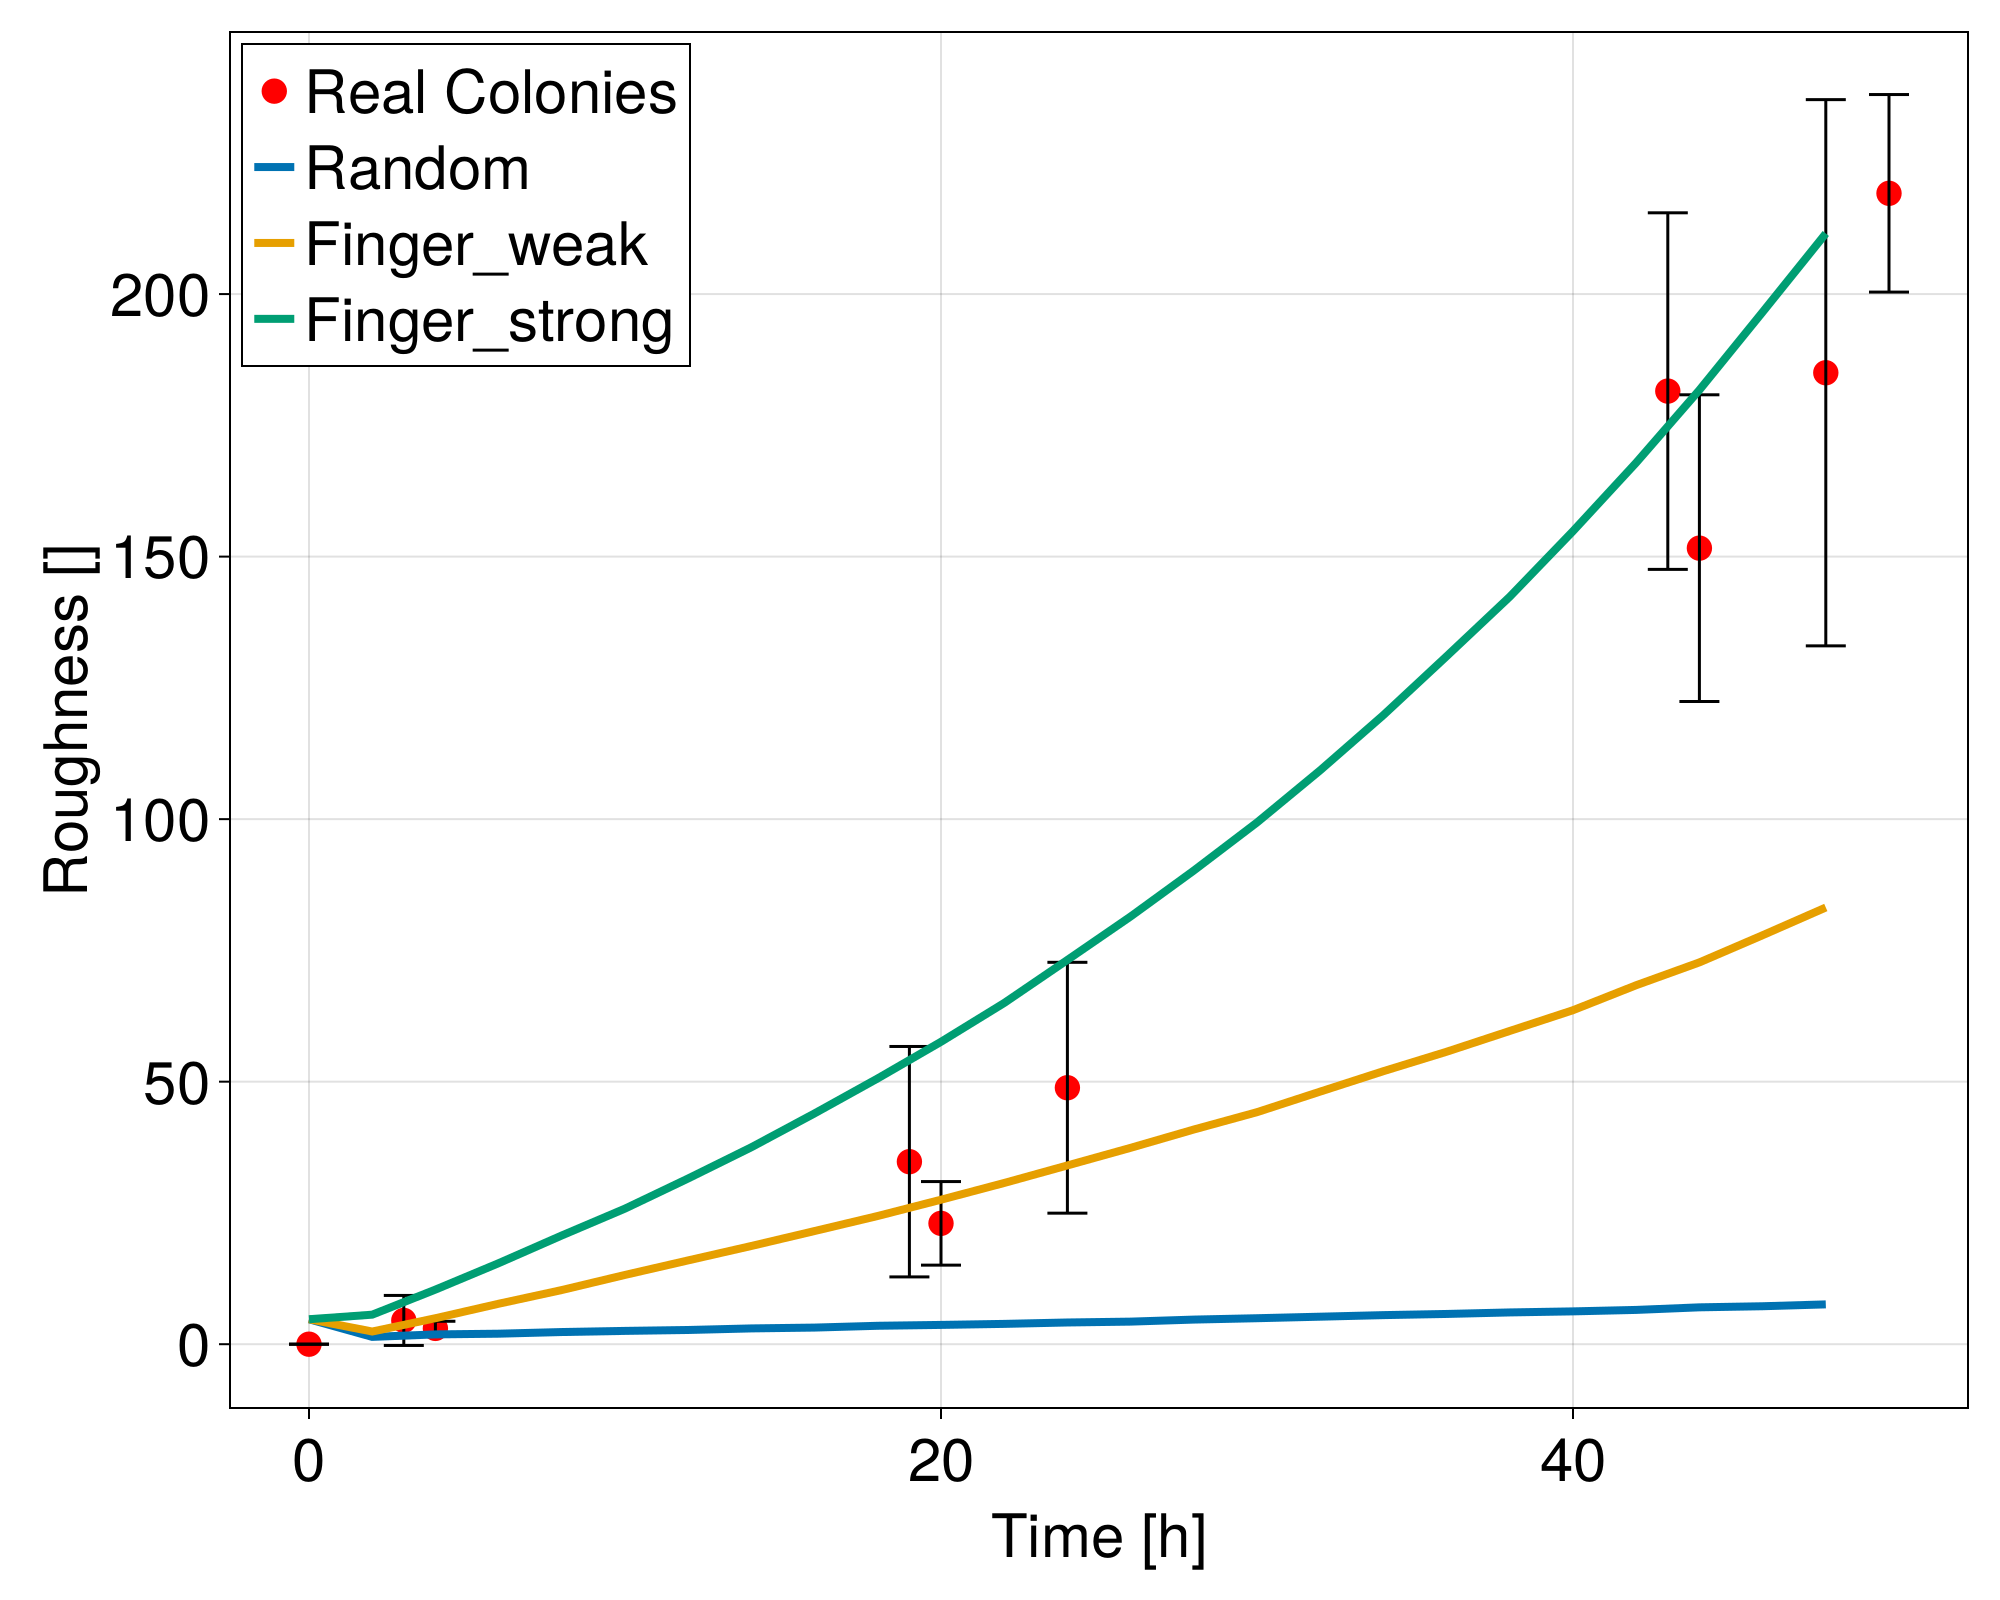

In [238]:
fig30 = Figure()
ax = CairoMakie.Axis(fig30[1,1])
scatter!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, color = "red")
errorbars!(ax,roughness_angular_max_r.time,roughness_angular_max_r.roughness_OG, roughness_angular_max_r.roughness_OG_std,color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Roughness []"
j = 1
for (k, i) in pairs(groupby(roughness_angular_max_single,:data_set))
    lines!(ax, i.time, i.roughness_angu, label = mk_label(k.data_set))
    #errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
axislegend(ax, position= :lt)
save(joinpath(path,"Comparision_RMS.pdf"),fig3)
fig30

## Fourier Transform on data set 

In [239]:
fft_data = @chain data_a begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data)



fft_data_r = @chain data_full begin 
    @transform(:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
    @transform(:abs_cov = [abs.(x[2:360÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:360÷2]) for x in :fourier_OG])
    @transform(:abs_cov_n = :abs_cov./:OG_size, :abs_OG_n = :abs_OG ./ :OG_size)

end
first(fft_data_r)
     


Row,data_set,colony,time,metric_cov,metric_OG,pair_OG,pair_cov,OG_size,fourier_conv,fourier_OG,abs_cov,abs_OG,abs_cov_n,abs_OG_n
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,Array…,Array…,Array…,Array…,Array…
1,14_06_23_stacked_full_res,Kolonie-1 seg.tif,0,"[0, 36, 51, 46, 47, 47, 48, 48, 46, 51 … 44, 51, 46, 47, 48, 47, 47, 46, 49, 109]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3117, 5369, 5589, 5610, 5596, 5626, 5537, 5642, 5434, 5611 … 5505, 5562, 5652, 5513, 5652, 5562, 5505, 5716, 5383, 2871]","[5338, 5545, 5520, 5777, 5550, 5610, 5518, 5535, 5527, 5602 … 5616, 5696, 5670, 5574, 5547, 5678, 5615, 5610, 5518, 5621]",16675,"ComplexF64[16675.0+0.0im, 99.5793-13.2053im, 43.3882+49.9286im, 135.108-24.3583im, 1.62511-53.0144im, -44.7534-30.9749im, -55.9687+52.126im, 72.7058+15.0427im, -17.9243-0.0067771im, 17.2809+22.9634im … -5.30812-45.8975im, 17.2809-22.9634im, -17.9243+0.0067771im, 72.7058-15.0427im, -55.9687-52.126im, -44.7534+30.9749im, 1.62511+53.0144im, 135.108+24.3583im, 43.3882-49.9286im, 99.5793+13.2053im]","ComplexF64[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im … 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]","[100.451, 66.1468, 137.287, 53.0393, 54.4271, 76.4828, 74.2457, 17.9243, 28.7393, 46.2034 … 140.776, 129.545, 74.5963, 145.949, 152.095, 135.649, 137.425, 149.264, 152.104, 142.672]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.00602405, 0.00396682, 0.00823308, 0.00318077, 0.003264, 0.00458667, 0.00445252, 0.00107492, 0.0017235, 0.00277082 … 0.00844231, 0.0077688, 0.00447354, 0.00875258, 0.00912113, 0.00813486, 0.0082414, 0.00895137, 0.00912167, 0.00855601]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [240]:
abs_fftw = @chain fft_data begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)) )
end
first(abs_fftw,3)

abs_fftw_single = @chain fft_data begin 
    groupby([:time,:data_set])
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)) )
end
last(abs_fftw_single,3)

Row,time,data_set,abs_og,abs_cov,abs_og_n,abs_cov_n
,Int64,String,Float64,Float64,Float64,Float64
1,44,Finger_strong 2023_12_20,1.84361e5,183609.0,8.95437,8.91782
2,46,Finger_strong 2023_12_20,1.97413e5,1.96666e5,9.58828,9.552
3,48,Finger_strong 2023_12_20,2.09219e5,2.08466e5,10.1617,10.1251


In [241]:
abs_fftw_r = @chain fft_data_r begin 
    groupby(:time)
    @combine(:abs_og = mean(sum.(:abs_OG)) , :abs_cov = mean(sum.(:abs_cov)),:abs_og_n = mean(sum.(:abs_OG_n)),:abs_cov_n = mean(sum.(:abs_cov_n)),:abs_og_n_std = std(sum.(:abs_OG_n)) )
end
last(abs_fftw_r,3)

Row,time,abs_og,abs_cov,abs_og_n,abs_cov_n,abs_og_n_std
,Int64,Float64,Float64,Float64,Float64,Float64
1,44,2.61143e5,2.59082e5,17.0809,16.9521,3.08389
2,48,3.32596e5,3.30848e5,16.1378,16.0472,4.90487
3,50,3.6632e5,3.64281e5,21.7879,21.6687,2.94679


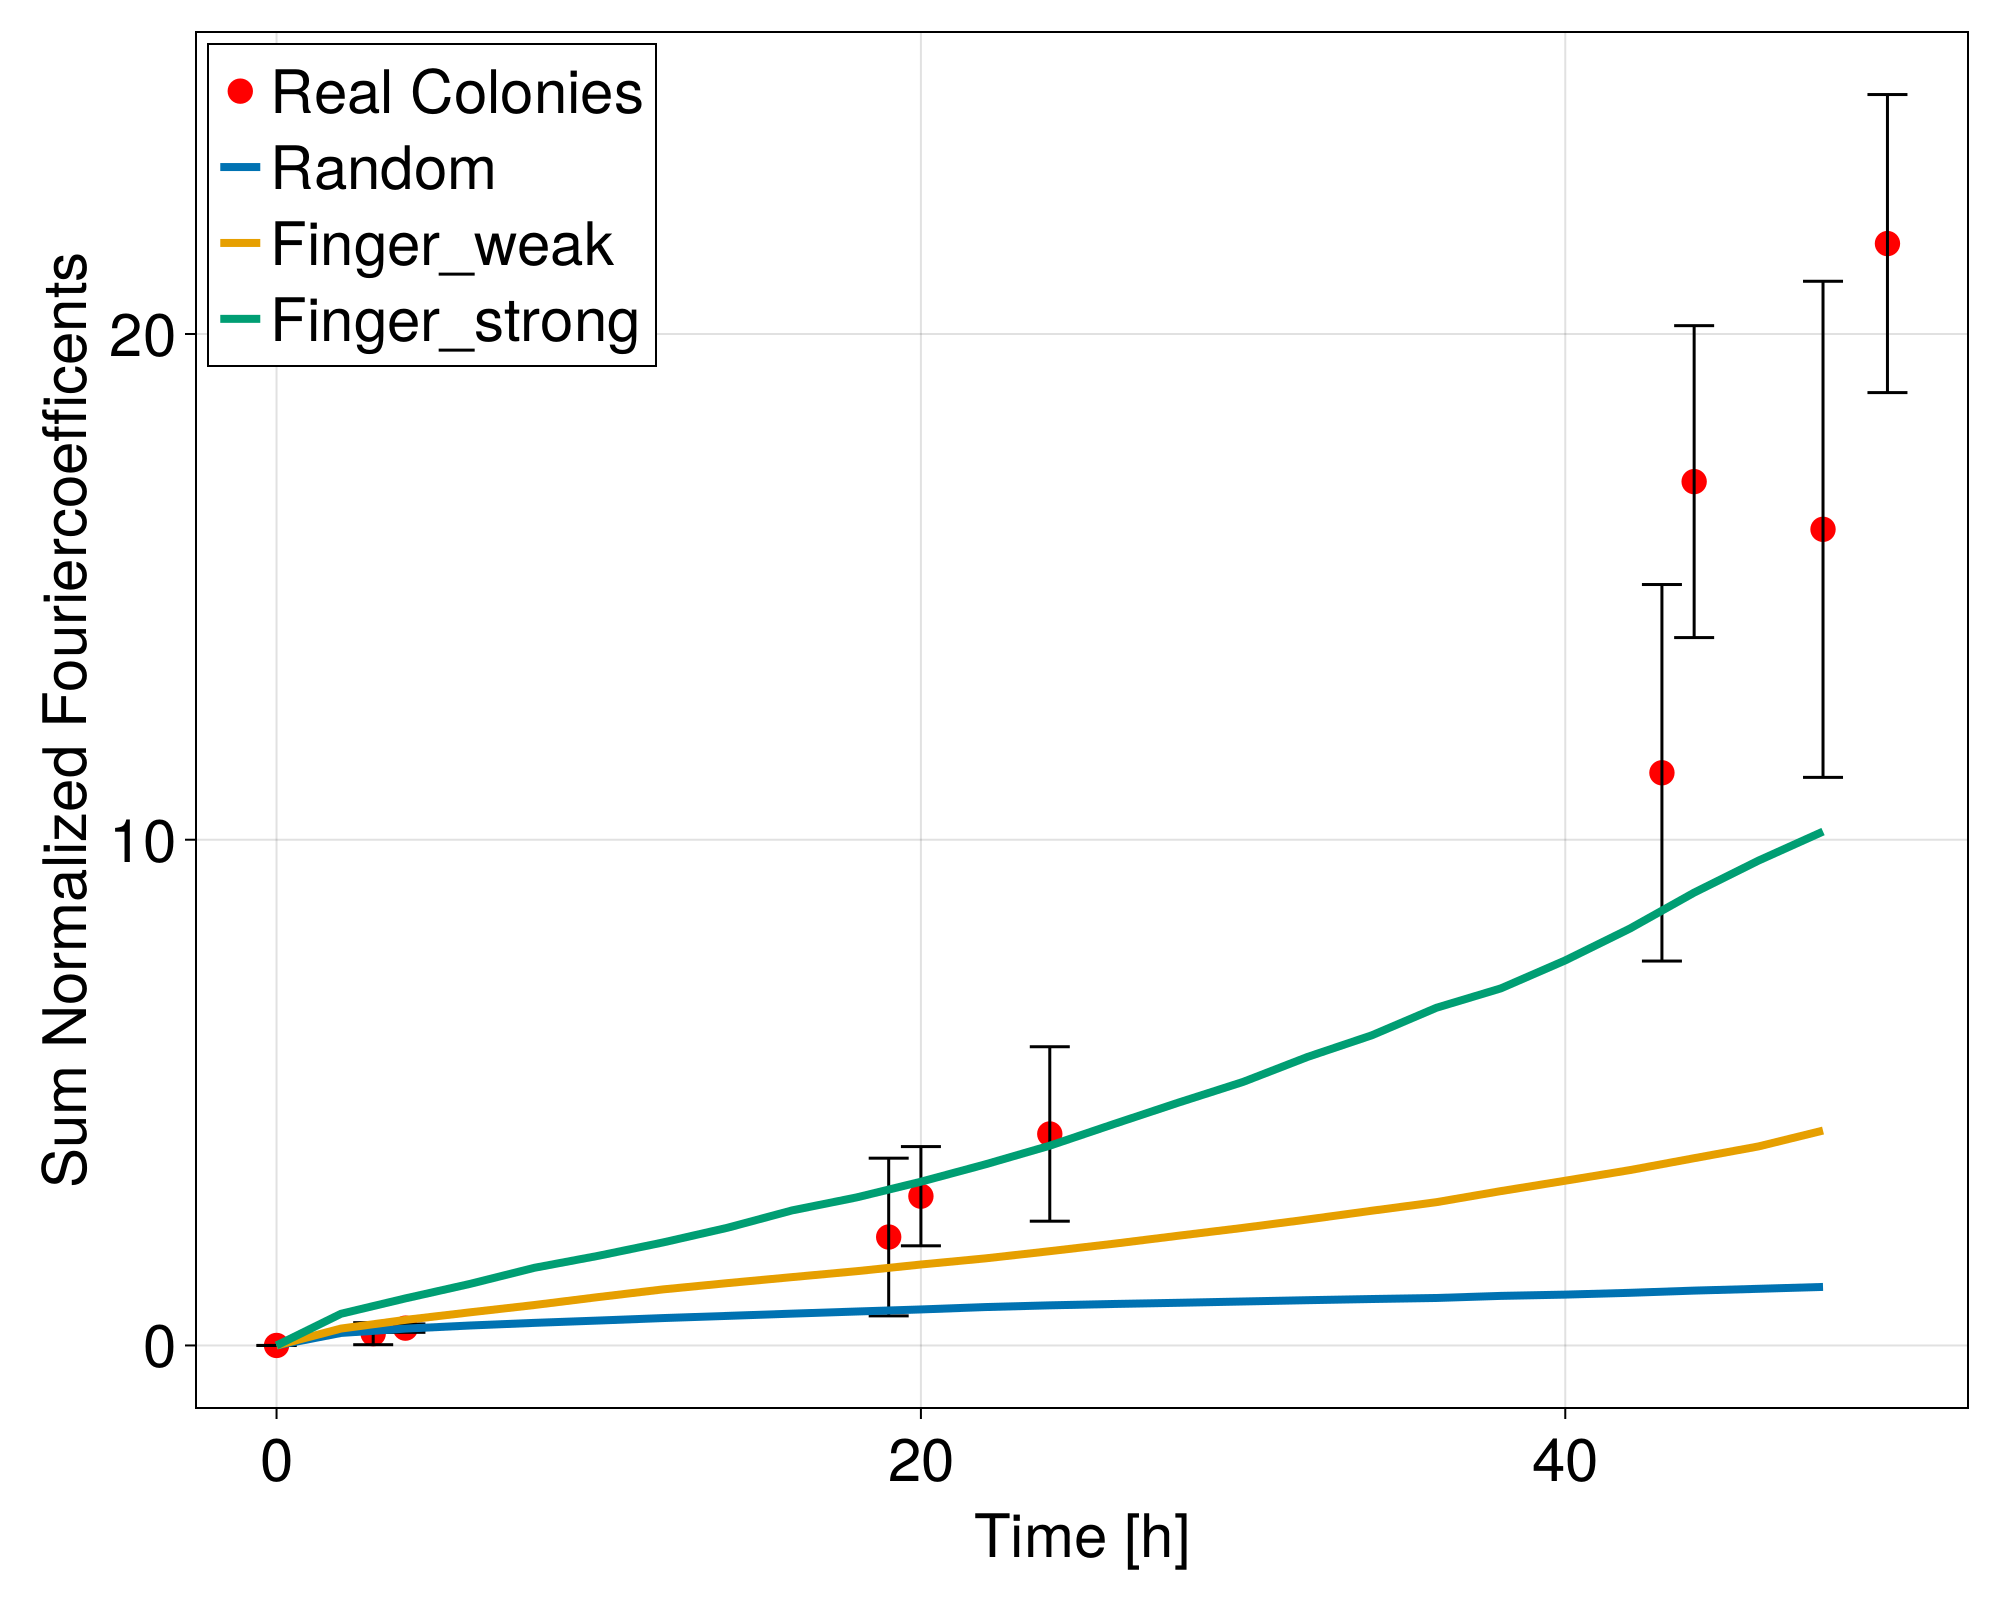

In [242]:
fig5 = Figure()
ax = CairoMakie.Axis(fig5[1,1])
scatter!(ax,abs_fftw_r.time, abs_fftw_r.abs_og_n, color = "red") 
errorbars!(ax, abs_fftw_r.time, abs_fftw_r.abs_og_n , abs_fftw_r.abs_og_n_std, color = :black)
ax.xlabel ="Time [h]"
ax.ylabel ="Sum Normalized Fouriercoefficents"
j = 1
for (k, i) in pairs(groupby(abs_fftw_single,:data_set))
    lines!(ax, i.time, i.abs_og_n, label = mk_label(k.data_set))
    #errorbars!(ax, i.time, i.pair_og,i.pair_og_stdd )
    j += 1
end
axislegend(ax, position = :lt)
save(joinpath(path,"Comparision_fourier_coeff.pdf"),fig5)
fig5

In [243]:
all_frequ = vcat(filter_fourier_beta.(fft_data.abs_OG_n)...);
fft_data_r_old = @subset(fft_data_r, :time .> 10)
fft_data_a_old = @subset(fft_data, :time .> 10);

In [244]:
histo_data_r = vcat(find_freq.(filter_fourier_beta.(fft_data_r.abs_OG_n, b  =0.5))...);

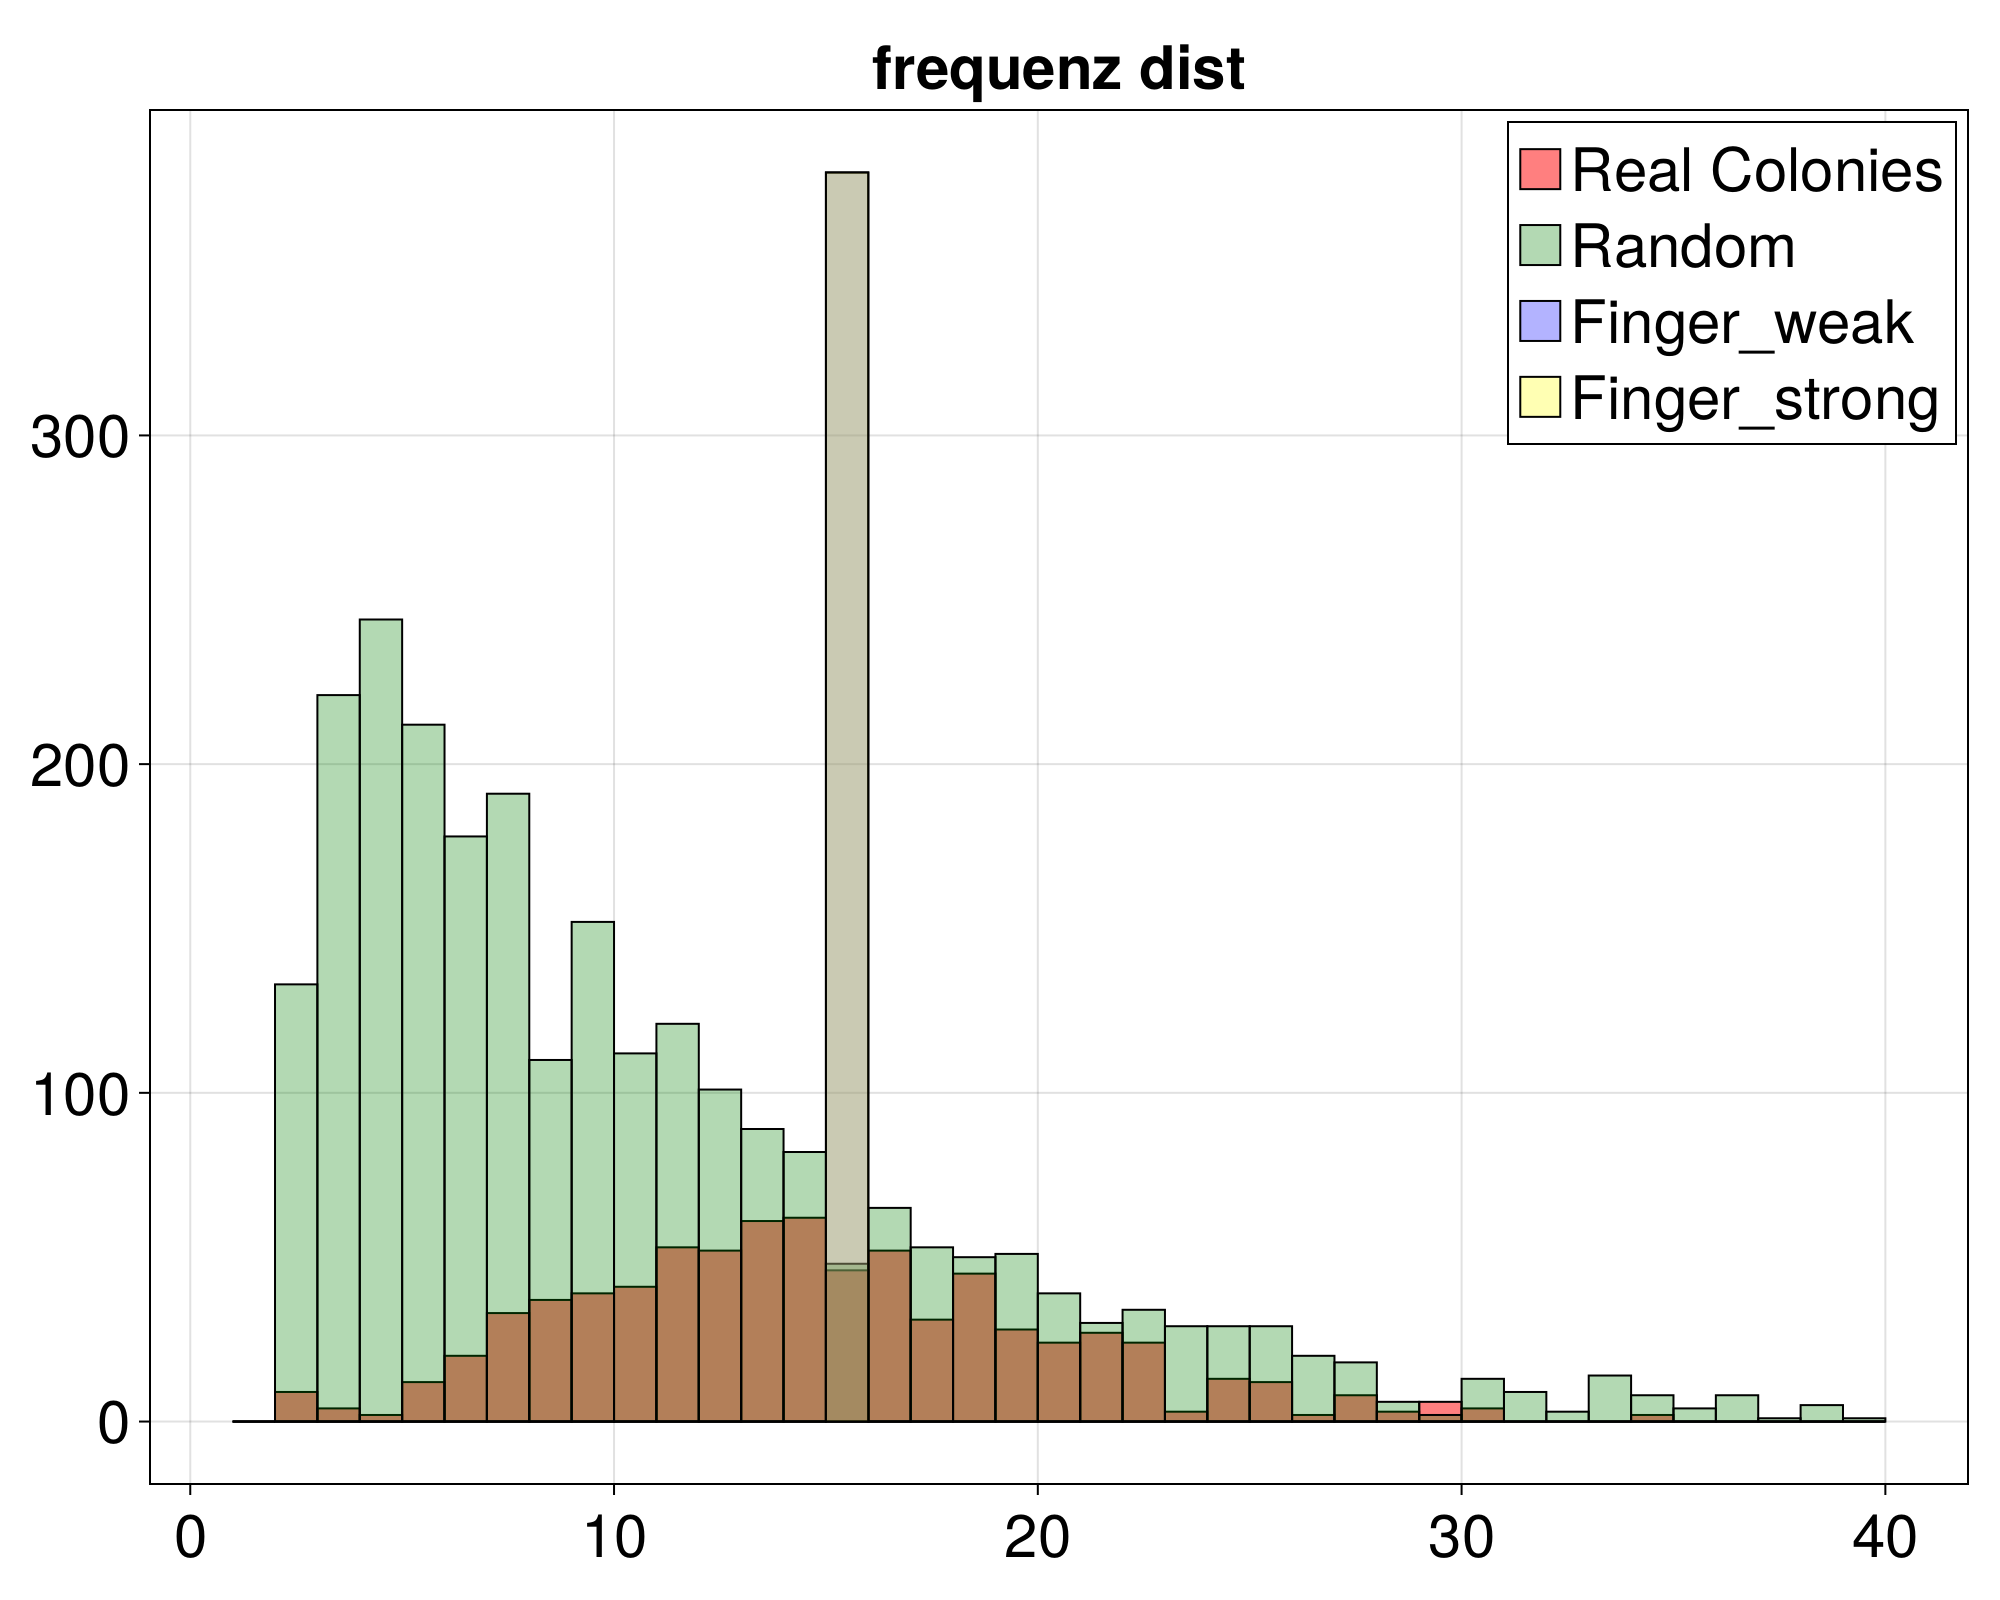

In [246]:
histo_data_a_vec = []
color_vec =[:green, :blue, :yellow, :orange, :purple, :black, :pink, :cyan, :magenta]

hans = Figure()
ax = Axis(hans[1,1])
hist!(ax,histo_data_r, bins = 1:40,strokewidth = 1, color = (:red, 0.5), label = "Real Colonies")
c = 1
for (k,i) in pairs(groupby(fft_data_a_old,:data_set))
    push!(histo_data_a_vec, vcat(find_freq.(filter_fourier_beta.(i.abs_OG_n, b  =0.5))...))
    hist!(ax,histo_data_a_vec[end], bins = 1:40,strokewidth = 1, color = (color_vec[c], 0.3), label = mk_label(k.data_set))
    c += 1
end
ax.title =  "frequenz dist"
axislegend(ax, position = :rt)

hans

### Size increase measure in pixel in circular metric

In [45]:
first(data)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589


In [46]:
size_data = @chain data begin 
    groupby([:time])
    @combine(:abs_size = mean(sum.(:metric_cov)) ,:abs_size_normalized = mean(sum.(:metric_OG))./mean(:OG_size) ,:OG_size = mean(:OG_size) )
end

Row,time,abs_size,abs_size_normalized,OG_size
,Int64,Float64,Float64,Float64
1,0,20589.0,0.0,20589.0
2,6,1858.99,0.193479,20589.0
3,20,6337.47,0.799395,20589.0
4,24,8035.41,1.02457,20589.0
5,44,19564.9,2.6351,20589.0
6,48,22634.1,3.08894,20589.0


In [47]:
cor_size = size_data.abs_size_normalized.+1

6-element Vector{Float64}:
 1.0
 1.1934792243430958
 1.7993950046141145
 2.0245725873038998
 3.635102481907815
 4.088942517849337

In [48]:
ex(x,p) =(1+(p[1])).^x
p1 = [0.001]
fit2 = curve_fit(ex,size_data.time ,cor_size , p1)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.029773932609948355], [0.0, -0.000998509640892875, -0.001195471417507754, -0.0024594221588283283, 0.0010604677267647133, -8.651963199213242e-7], [0.0; 6.9480145714533945; … ; 155.3653344520713; 190.5944553056881;;], true, Float64[])

In [49]:
y2 = ex(size_data.time,fit2.param)
fit2.param

1-element Vector{Float64}:
 0.029773932609948355

In [50]:
1/fit2.param[1]

33.58642652619796

In [51]:
fit2.resid

6-element Vector{Float64}:
  0.0
 -0.000998509640892875
 -0.001195471417507754
 -0.0024594221588283283
  0.0010604677267647133
 -8.651963199213242e-7

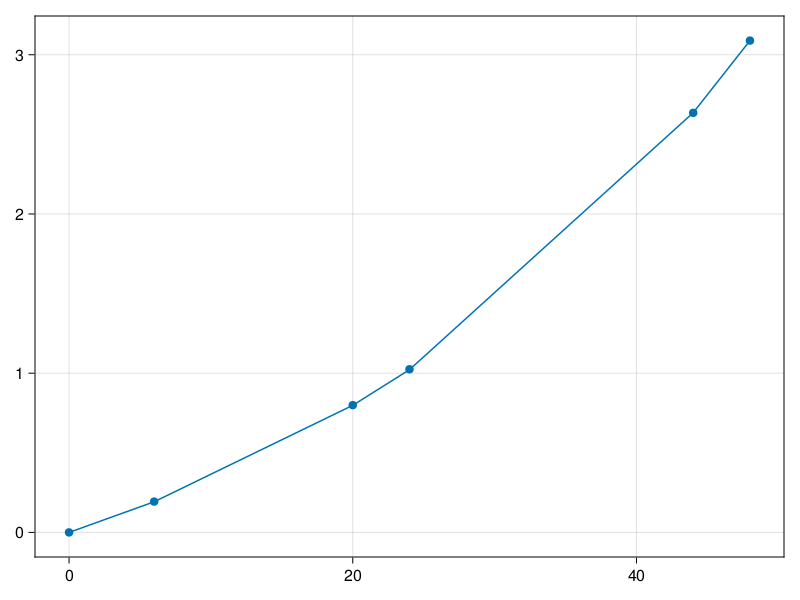

In [52]:
fig10 =scatter(size_data.time, size_data.abs_size_normalized)
lines!(fig10.axis, size_data.time, y2.-1)
fig10

In [53]:
first(data)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589


In [54]:
size(data)

(960, 8)

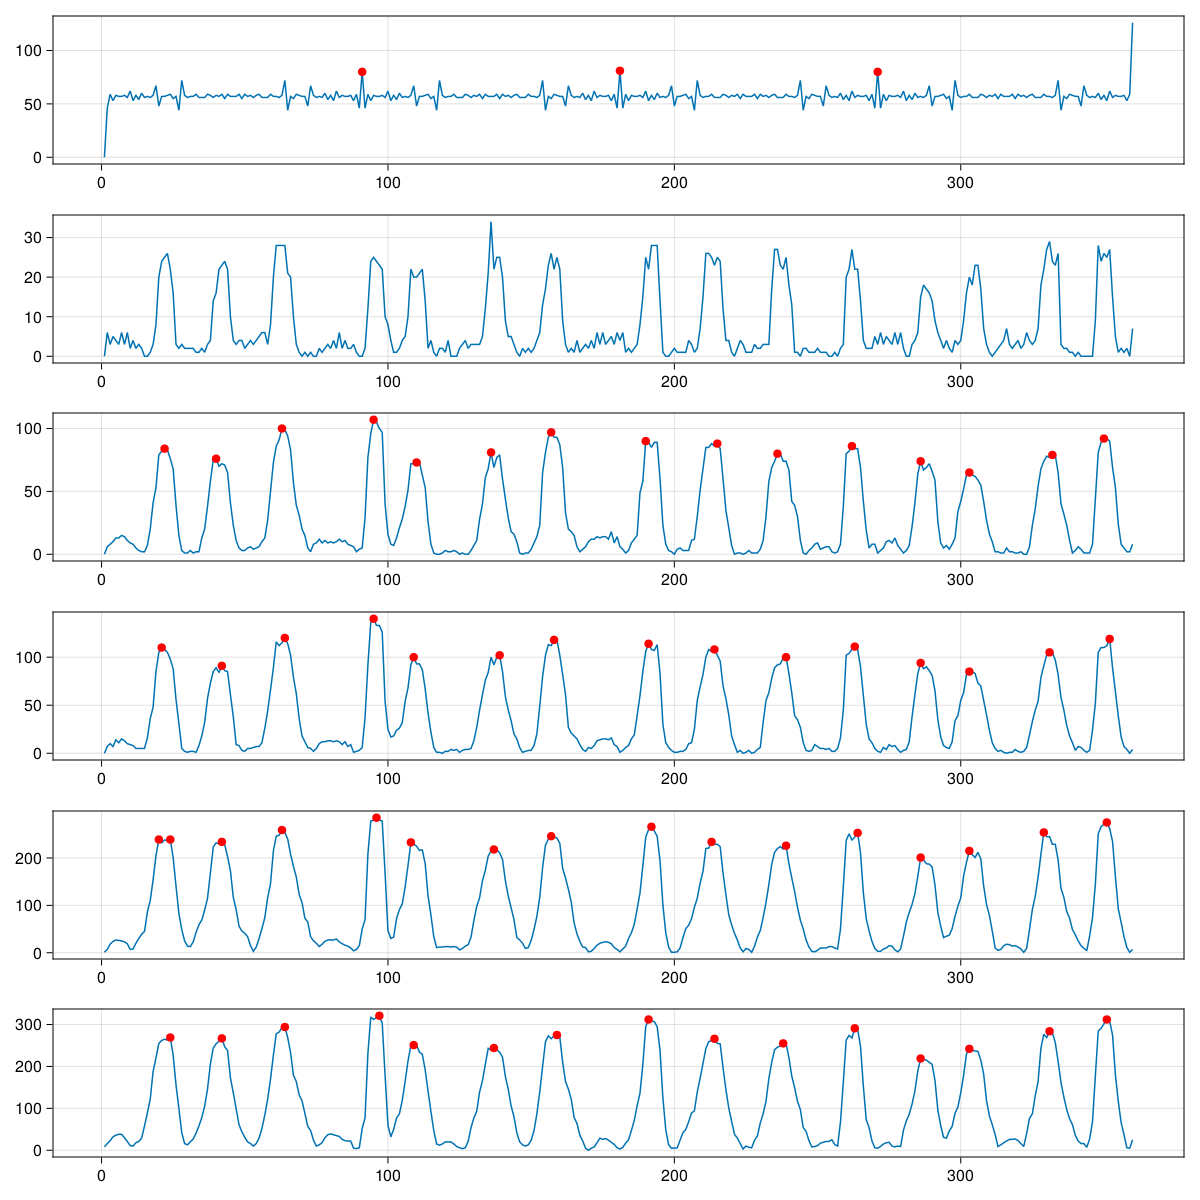

In [55]:
fig6 = Figure(resolution =(1200,1200))
for i in 1:6
    data1 = data.metric_cov[i+642];
    ax = CairoMakie.Axis(fig6[i,1])
    lines!(ax, data1)
    pkindices, properties = findpeaks1d(data1, prominence=0.6*mean(data1), distance = 4, height = 50)
    scatter!(ax, pkindices, data1[[pkindices...]],color = "red" )
end
fig6

In [56]:
peaks_full  = @chain data begin 
    @transform(:nr_peaks_cov = length.([findpeaks1d(i, prominence=0.4*mean(i), distance = 4, height = 40)[1] for i in :metric_cov])  )
end
first(peaks_full)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,nr_peaks_cov
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Int64
1,circular 2023_09_14,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 126]","[5555, 5546, 5447, 5537, 5552, 5563, 5499, 5483, 5464, 5574 … 5552, 5656, 5490, 5499, 5625, 5594, 5572, 5551, 5542, 5373]","[5471, 5497, 5554, 5544, 5645, 5485, 5664, 5577, 5650, 5612 … 5541, 5650, 5582, 5465, 5465, 5549, 5611, 5441, 5611, 5505]",20589,12


In [57]:
peaks_over_time = @chain peaks_full begin
    groupby(:time)
    @combine(:peaks_mean = mean(:nr_peaks_cov), :peaks_stdd =std(:nr_peaks_cov) )
end


Row,time,peaks_mean,peaks_stdd
,Int64,Float64,Float64
1,0,12.0,0.0
2,6,1.68125,3.3988
3,20,5.98125,7.35401
4,24,6.025,7.40894
5,44,6.1625,7.20926
6,48,6.325,7.0582


In [58]:
peaks_over_time_all = @chain peaks_full begin
    groupby([:time,:data_set])
    @combine(:peaks_mean = mean(:nr_peaks_cov), :peaks_stdd =std(:nr_peaks_cov) )
end

Row,time,data_set,peaks_mean,peaks_stdd
,Int64,String,Float64,Float64
1,0,circular 2023_09_14,12.0,0.0
2,6,circular 2023_09_14,0.0,0.0
3,20,circular 2023_09_14,0.0,0.0
4,24,circular 2023_09_14,0.0,0.0
5,44,circular 2023_09_14,0.0,0.0
6,48,circular 2023_09_14,0.0,0.0
7,0,random 2023_09_14,12.0,0.0
8,6,random 2023_09_14,0.0,0.0
9,20,random 2023_09_14,0.0,0.0


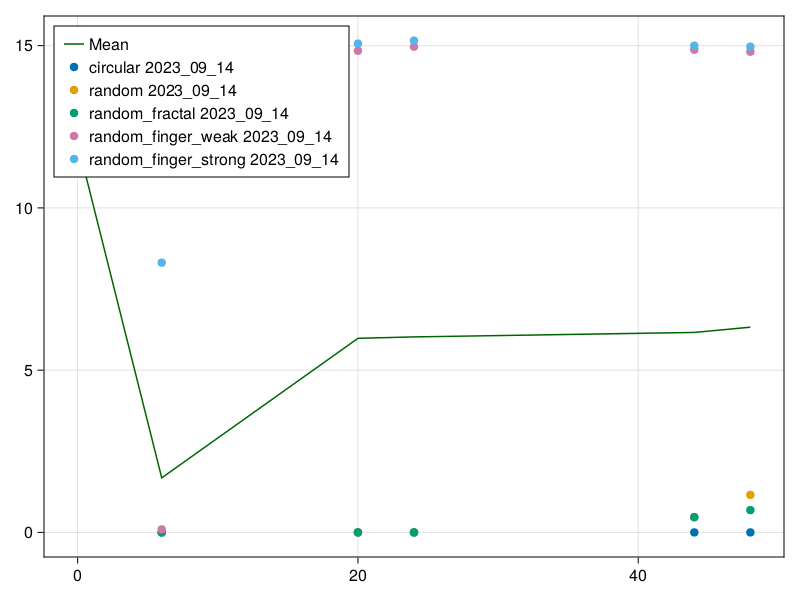

In [59]:
fig7 = lines(peaks_over_time.time,peaks_over_time.peaks_mean, color = "darkgreen", whiskerwidth = 10, label = "Mean")

for (k, i) in pairs(groupby(peaks_over_time_all,:data_set))
    scatter!(fig7.axis, i.time, i.peaks_mean, label = String(k.data_set))
end
axislegend(fig7.axis, position = :lt)
fig7


In [60]:
fIndex_fil = @chain df_f begin 
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:data_stet = :data_set[1],:fil_OG = mean(sum.(:abs_OG)), :fil_cov = mean(sum.(:abs_cov)))
end

LoadError: UndefVarError: `df_f` not defined

In [61]:
pair_10 = @chain data begin
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:pair_og = mean((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)),
        :pair_og_stdd =std((maximum.(:pair_OG).-mean.(:pair_OG))./mean.(:pair_OG)) )
    

end

Row,time,pair_og,pair_og_stdd
,Int64,Float64,Float64


In [62]:
fig = CairoMakie.scatter(pair_10.pair_og)
errorbars!(1:length(pair_10.time),pair_10.pair_og, pair_10.pair_og_stdd,whiskerwidth = 10)
fig

LoadError: `Makie.convert_arguments` for the plot type LineSegments{Tuple{Vector{Any}}} and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Any}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://docs.makie.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


In [49]:
data_14 = @subset(data,:data_set .== "14_06_23_stacked_full_res")
first(data_14,3)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
